# Benchmark random and pseudo-random solvers on Multi-objective problems

In [1]:
import time
import sys
import datetime
from random import uniform
sys.path.append('..')

# --- Dependencies
import pygmo as pg
import numpy as np
import pandas as pd
import sobol_seq
# import dovpanda

import plotly
from plotly import graph_objs as go
from plotly import tools
import plotly.express as px

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score

# from src.generator import SamplesGenerator
# from src.composite import PredictTutor, ModelsUnion
from src.ploting import plot_mo
# from src.search import Nsga2
# from src.hypothesis.custom_gp_kernel import KERNEL_MAUNA, KERNEL_SIMPLE, KERNEL_GPML

## Sampling strategies
- Random
- Sobol
- Latin hypercube

In [2]:
def sobol_sample(bounds=([0., 0.], [5., 5.]), n=1):
    """ Sobol sampling

    Args:
        bounds (Tuple):  Tuple with lower and higher bound for each feature in objective space.
        Example: (([0., 0.]), ([2., 4.]))
        n (int, optional): Sample count. Defaults to 1.

    Returns:
        List: 2D list of point(s) from search space
    """
    n_dim = len(bounds[0])
    sb = sobol_seq.i4_sobol_generate(n_dim, n, 1)
    diff = [r-l for l, r in zip(*bounds)]
    left = [l for l, _ in zip(*bounds)]
    return (sb*diff+left).tolist()


def lh_sample(bounds=([0., 0.], [5., 5.]), n=1):
    """ Latin Hypercube sampling

    Args:
        bounds (Tuple):  Tuple with lower and higher bound for each feature in objective space.
        Example: (([0., 0.]), ([2., 4.]))
        n (int, optional): Sample count. Defaults to 1.

    Returns:
        List: 2D list of point(s) from search space
    """
    n_dim = len(bounds[0])
    h_cube = np.random.uniform(size=[n, n_dim])
    for i in range(0, n_dim):
        h_cube[:, i] = (np.argsort(h_cube[:, i])+0.5)/n
    diff = [r-l for l, r in zip(*bounds)]
    left = [l for l, _ in zip(*bounds)]
    return (h_cube*diff+left).tolist()
    
def random_sample(bounds=([0., 0.], [5., 5.]), n=1):
    """ Random sampling

    Args:
        bounds (Tuple):  Tuple with lower and higher bound for each feature in objective space.
        Example: (([0., 0.]), ([2., 4.]))
        n (int, optional): Sample count. Defaults to 1.

    Returns:
        List: 2D list of point(s) from search space
    """
    v_uniform = np.vectorize(uniform)
    return [v_uniform(*bounds).tolist() for _ in range(n)]

In [3]:
# px.scatter(pd.DataFrame(random_sample(n=20), columns=['param 1', 'param 2']), x='param 1', y='param 2', template="presentation", marginal_y="rug", marginal_x="rug", title="Random sampling")

In [4]:
# px.scatter(pd.DataFrame(sobol_sample(n=20), columns=['param 1', 'param 2']), x='param 1', y='param 2', template="presentation", marginal_y="rug", marginal_x="rug", title="Sobol sampling")

In [5]:
# px.scatter(pd.DataFrame(lh_sample(n=20), columns=['param 1', 'param 2']), x='param 1', y='param 2', template="presentation", marginal_y="rug", marginal_x="rug", title="Latin Hypercube sampling")

## Benchmark function

In [6]:
def make_nd_pop(pro, x, y):
    nd_front = pg.fast_non_dominated_sorting(y)[0][0]
    nd_x = np.array(x)[nd_front]
    nd_y = np.array(y)[nd_front]
    t_pop = pg.population(pro)
    for i, p_vector in enumerate(nd_x):
        t_pop.push_back(x=p_vector, f=nd_y[i])
    return t_pop

def experiment(problem_name: str,
               prob_id: int,
               prob_dim: int,
               obj: int,
               random_points: int,
               sampling_plan: str,
               seed=None):
    
    np.random.seed(seed)

    result = {
        "problem_name": problem_name,
        "seed": seed,
        "problem_id": prob_id,
        "objectives": obj,
        "feature_dim": prob_dim,
        "random_points": random_points,
        "sampling_plan": sampling_plan,
        "ndf_x": '',
        "ndf_f": '',
        "fevals": '',
        "evolve_time": '',
        "date": '',
        "p_distance": '',
        "hypervolume": '',
        "ndf_space": '',
        "ndf_size": '',
        'error': '',
        'final': False
    }

    # ----------------------                                                            Initialize problem
    try:
        if problem_name is 'wfg':
            udp = pg.wfg(prob_id=prob_id, dim_dvs=prob_dim,
                         dim_obj=obj, dim_k=obj-1)
        elif problem_name is 'zdt':
            udp = pg.zdt(prob_id=prob_id, param=prob_dim)
        elif problem_name is 'dtlz':
            udp = pg.dtlz(prob_id=prob_id, dim=prob_dim, fdim=obj)
        prob = pg.problem(udp)
    except Exception as err:
        result['error'] = "Init problem: {}".format(err)
        return result

    # ----------------------                                                            Sampling plan initialization
    try:
        points = None
        if sampling_plan is 'random':
            points = random_sample(bounds=prob.get_bounds(), n=random_points)
        elif sampling_plan is 'sobol':
            points = sobol_sample(bounds=prob.get_bounds(), n=random_points)
        elif sampling_plan is 'latin':
            points = lh_sample(bounds=prob.get_bounds(), n=random_points)
        else:
            raise ValueError(f"{sampling_plan}. Parameter error! Acceptable values: 'random','sobol','latin'")
    except Exception as err:
        result['error'] = "Sampling plan initialization: {}".format(err)
        return result

    
    # ----------------------                                                            Solving
    evolve_start = time.time()
    try:
        points_f = pg.bfe()(prob, np.array(points).flatten()).reshape(-1, obj).tolist()
        
        result["fevals"] = prob.get_fevals()
        #This returns the first (i.e., best) non-dominated individual from population:
        nd_pop = make_nd_pop(prob, points, points_f)
        
        score = udp.p_distance(nd_pop) if hasattr(udp, 'p_distance') else None
        
        result["p_distance"] = score or None
        result["ndf_x"] = nd_pop.get_x().tolist()
        result["ndf_f"] = nd_pop.get_f().tolist()
        result["ndf_size"] = len(nd_pop.get_f())
    except Exception as err:
        result['error'] = "Evolve: {}".format(err)
        return result

    # ----------------------                                                            Hypervolume
    try:
        hypervolume = pg.hypervolume(-nd_pop.get_f()
                                    ).compute([0]*nd_pop.problem.get_nobj())
        result['hypervolume'] = hypervolume or None
    except Exception as err:
        result['error'] = "Hypervolume: {}".format(err)
        return result
    
    # ----------------------                                                            Spacing metric
    # The spacing metric aims at assessing the spread (distribution)
    # of vectors throughout the set of nondominated solutions. 
    try:
        dist = pg.crowding_distance(points = nd_pop.get_f())
        not_inf_dist = dist[np.isfinite(dist)]
        mean_dist = np.mean(not_inf_dist)
        space_m = (sum([(mean_dist - d)**2 for d in not_inf_dist])/(len(not_inf_dist)-1))**(1/2)
        result["ndf_space"] = space_m
    except Exception as err:
        result['error'] = "Spacing metric: {}".format(err)
        return result

    # ----------------------                                                            Write results
    
    try:
        t_end = time.time()

        result["problem_name"] = nd_pop.problem.get_name()
        result["objectives"] = nd_pop.problem.get_nobj()
        result["feature_dim"] = nd_pop.problem.get_nx()
        result["evolve_time"] = t_end - evolve_start
        result["date"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
        result["final"] = True
        result["sampling_plan"] = sampling_plan
        

    except Exception as err:
        result['error'] = "Write results: {}".format(err)

    return result

## Parameter grid

In [7]:
param_grid = {
            'problem_name': ['wfg'],
            'prob_id': [4],
            'prob_dim': [2],
            'obj': [2],
            'random_points': [300,10000],
            'sampling_plan': ['latin'],
            'seed': [774]
        }

res = []
i = 0
for p in ParameterGrid(param_grid):
    i = i+1
    print("\n Evaluation.: {} \n i: {}".format(p, i))
    res.append(experiment(**p))

pd.DataFrame(res)


 Evaluation.: {'obj': 2, 'prob_dim': 2, 'prob_id': 4, 'problem_name': 'wfg', 'random_points': 300, 'sampling_plan': 'latin', 'seed': 774} 
 i: 1

 Evaluation.: {'obj': 2, 'prob_dim': 2, 'prob_id': 4, 'problem_name': 'wfg', 'random_points': 10000, 'sampling_plan': 'latin', 'seed': 774} 
 i: 2


problem_name  seed  problem_id  objectives  feature_dim  random_points  \
0         WFG4   774           4           2            2            300   
1         WFG4   774           4           2            2          10000   

  sampling_plan                                              ndf_x  \
0         latin  [[1.99, 1.82], [1.5566666666666666, 1.58], [0....   
1         latin  [[0.7133, 1.5726], [1.4763, 1.401], [0.1547, 1...   

                                               ndf_f  fevals  evolve_time  \
0  [[2.0112727798012315, 0.5819218461811542], [1....     300     0.005173   
1  [[0.36426820467833093, 3.9394922364029648], [1...   10000     2.088018   

               date p_distance  hypervolume  ndf_space  ndf_size error  final  
0  2020-02-25 12:07       None     6.559020   0.082757        32         True  
1  2020-02-25 12:07       None     6.295351   0.017210       138         True

## Benchmark results

Questions
1. Whith sampling strategies gieves beter distributions of non-dominated points?
2. How much points from sampling rate is non-dominated? 

Parameters grid:
```json
[
        {
            'problem_name': ['wfg'],
            'prob_id': [1, 2, 3, 4, 5, 6, 7, 8, 9],
            'prob_dim': [2, 4, 6, 8, 10],
            'obj': [2, 4, 6, 8, 10],
            'random_points': [40, 100, 200, 400, 800, 5000, 10000],
            'sampling_plan': ['sobol', 'random', 'latin'],
            'seed': [42, 72, 112, 774]
        },
        {
            'problem_name': ['zdt'],
            'prob_id': [1, 2, 3, 4, 5, 6],
            'prob_dim': [2, 4, 6, 8, 10],
            'obj': [2, 4, 6, 8, 10],
            'random_points': [40, 100, 200, 400, 800, 5000, 10000],
            'sampling_plan': ['sobol', 'random', 'latin'],
            'seed': [42, 72, 112, 774]
        },
        {
            'problem_name': ['dtlz'],
            'prob_id': [1, 2, 3, 4, 5, 6, 7],
            'prob_dim': [2, 4, 6, 8, 10],
            'obj': [2, 4, 6, 8, 10],
            'random_points': [40, 100, 200, 400, 800, 5000, 10000],
            'sampling_plan': ['sobol', 'random', 'latin'],
            'seed': [42, 72, 112, 774]
        }
    ]

```

In [10]:
df_wfg_res = pd.read_csv("./data/Random_on_wfg_i18900.i65z5ut0xd.csv").query("final==True").drop(['ndf_x', 'ndf_f'], axis=1)
df_dllz_res = pd.read_csv("./data/Random_on_dtlz_i14700.fldbu6fei1.csv").query("final==True").drop(['ndf_x', 'ndf_f'], axis=1)
df_zdt_res = pd.read_csv("./data/Random_on_zdt_i12600.oyw7t8tkjl.csv").query("final==True").drop(['ndf_x', 'ndf_f'], axis=1)

In [11]:
df_wfg_res

problem_name  seed  problem_id  objectives  feature_dim  random_points  \
0             WFG1    42           1           2            2             40   
1             WFG1    72           1           2            2             40   
2             WFG1   112           1           2            2             40   
3             WFG1   774           1           2            2             40   
4             WFG1    42           1           2            2             40   
...            ...   ...         ...         ...          ...            ...   
18895         WFG9   774           9          10           10          10000   
18896         WFG9    42           9          10           10          10000   
18897         WFG9    72           9          10           10          10000   
18898         WFG9   112           9          10           10          10000   
18899         WFG9   774           9          10           10          10000   

      sampling_plan   fevals  evolve_time              date  p_distance  \
0             sobol     40.0     0.001962  2020-02-18 19:28         NaN   
1             sobol     40.0     0.000496  2020-02-18 19:28         NaN   
2             sobol     40.0     0.000453  2020-02-18 19:28         NaN   
3             sobol     40.0     0.000426  2020-02-18 19:28         NaN   
4            random     40.0     0.000469  2020-02-18 19:28         NaN   
...             ...      ...          ...               ...         ...   
18895        random  10000.0     9.017793  2020-02-18 22:00         NaN   
18896         latin  10000.0     8.783876  2020-02-18 22:00         NaN   
18897         latin  10000.0     9.496617  2020-02-18 22:00         NaN   
18898         latin  10000.0     9.139030  2020-02-18 22:00         NaN   
18899         latin  10000.0     8.655092  2020-02-18 22:00         NaN   

        hypervolume  ndf_space  ndf_size error  final  
0      3.273369e+00   0.168550       6.0   NaN   True  
1      3.273369e+00   0.168550       6.0   NaN   True  
2      3.273369e+00   0.168550       6.0   NaN   True  
3      3.273369e+00   0.168550       6.0   NaN   True  
4      4.431293e+00   0.814090       5.0   NaN   True  
...             ...        ...       ...   ...    ...  
18895  2.084313e+06   0.008960    4495.0   NaN   True  
18896  1.780337e+06   0.007955    4540.0   NaN   True  
18897  1.618867e+06   0.008642    4465.0   NaN   True  
18898  1.629206e+06   0.007387    4545.0   NaN   True  
18899  1.983982e+06   0.008019    4467.0   NaN   True  

[7888 rows x 16 columns]

In [18]:
# px.line(df_wfg_res, x="random_points", y="ndf_size", color="objectives", render_mode="svg")

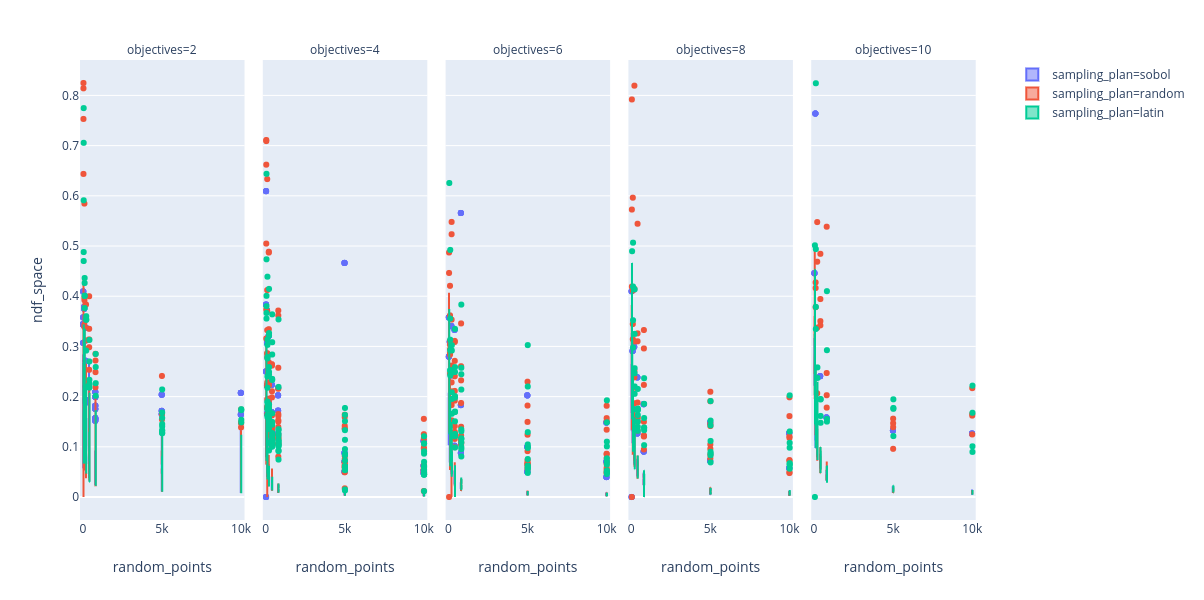

In [17]:
# df = df_wfg_res.query("objectives==2")[['hypervolume', 'problem_name', 'sampling_plan', 'random_points', 'ndf_size']]
# px.line(df_wfg_res, x="random_points", y="hypervolume", color="problem_name", hover_name="ndf_space", render_mode="svg")

df = df_wfg_res
px.box(df, x="random_points", y="ndf_space", color="sampling_plan", facet_col="objectives", notched=True)

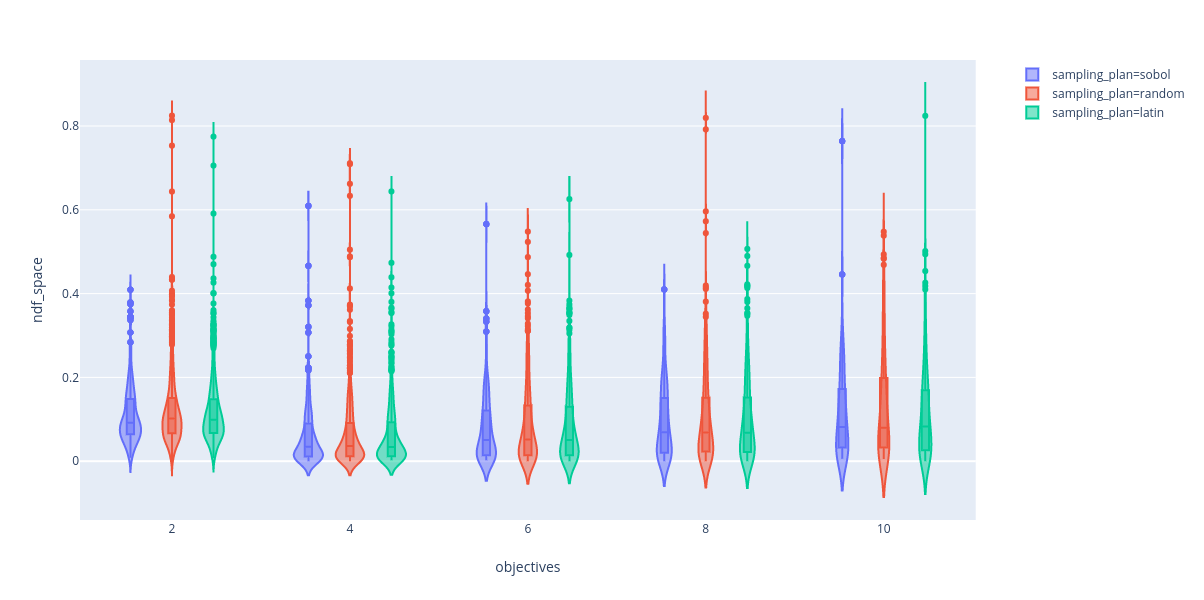

In [15]:
# .query("feature_dim==10")
df = df_wfg_res
px.violin(df, y="ndf_space", x="objectives", color="sampling_plan", box=True, hover_data=df.columns)

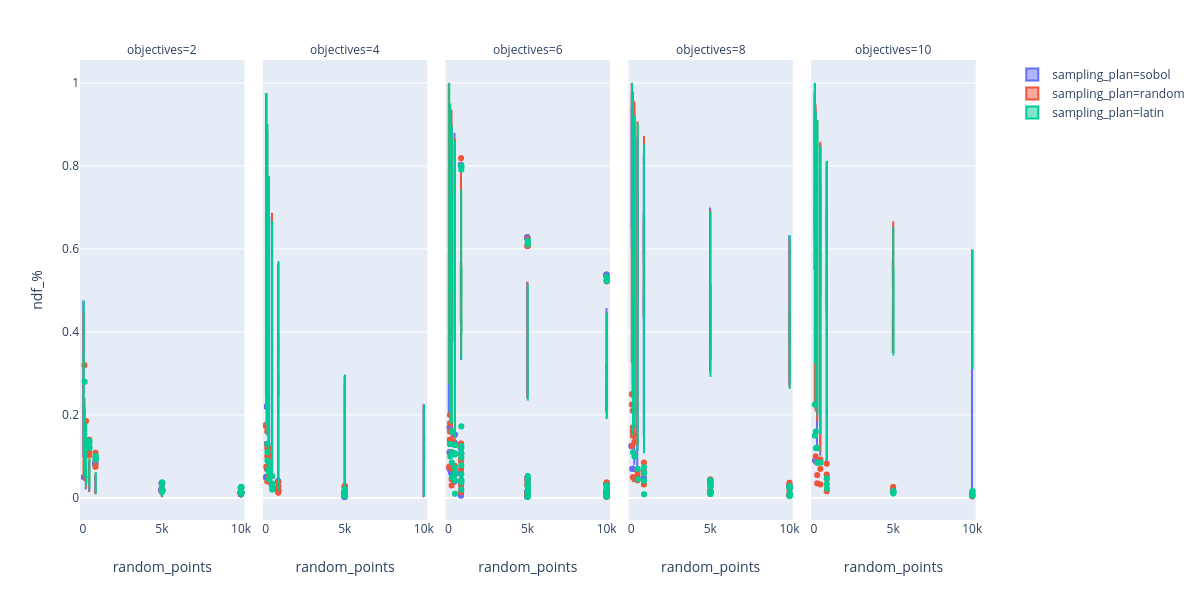

In [16]:
df = df_wfg_res
df["ndf_%"] = df["ndf_size"]/df["fevals"]
px.box(df, x="random_points", y="ndf_%", color="sampling_plan", facet_col="objectives", notched=True)